In [1]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# Helper functions

In [2]:

def log_prior(model, theta_mu=None, sigma=None):
    # params -
    # TODO de-spaghettize this once the priors are coded properly
    prior_dict = {'SE': {'raw_lengthscale' : {"mean": -0.21221139138922668 , "std":1.8895426067756804}},
                  'MAT52': {'raw_lengthscale' :{"mean": 0.7993038925994188, "std":2.145122566357853 } },
                  'MAT32': {'raw_lengthscale' :{"mean": 1.5711054238673443, "std":2.4453761235991216 } },
                  'RQ': {'raw_lengthscale' :{"mean": -0.049841950913676276, "std":1.9426354614713097 },
                          'raw_alpha' :{"mean": 1.882148553921053, "std":3.096431944989054 } },
                  'PER':{'raw_lengthscale':{"mean": 0.7778461197268618, "std":2.288946656544974 },
                          'raw_period_length':{"mean": 0.6485334993738499, "std":0.9930632050553377 } },
                  'LIN':{'raw_variance' :{"mean": -0.8017903983055685, "std":0.9966569921354465 } },
                  'c':{'raw_outputscale':{"mean": -1.6253091096349706, "std":2.2570021716661923 } },
                  'noise': {'raw_noise':{"mean": -3.51640656386717, "std":3.5831320474767407 }}}
    #prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
    #              "MAT": {"raw_lengthscale": {"mean": 1.631, "std": 2.554}},
    #              "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636},
    #                      "raw_period_length": {"mean": 0.284, "std": 0.902}},
    #              "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
    #              "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
    #              "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    variances_list = list()
    debug_param_name_list = list()
    theta_mu = list()
    params = list()
    covar_string = gsr(model.covar_module)
    covar_string = covar_string.replace("(", "")
    covar_string = covar_string.replace(")", "")
    covar_string = covar_string.replace(" ", "")
    covar_string = covar_string.replace("PER", "PER+PER")
    covar_string_list = [s.split("*") for s in covar_string.split("+")]
    covar_string_list.insert(0, ["LIKELIHOOD"])
    covar_string_list = list(chain.from_iterable(covar_string_list))
    both_PER_params = False
    for (param_name, param), cov_str in zip(model.named_parameters(), covar_string_list):
        params.append(param.item())
        debug_param_name_list.append(param_name)
        # First param is (always?) noise and is always with the likelihood
        if "likelihood" in param_name:
            theta_mu.append(prior_dict["noise"]["raw_noise"]["mean"])
            variances_list.append(prior_dict["noise"]["raw_noise"]["std"])
            continue
        else:
            if (cov_str == "PER" or cov_str == "RQ") and not both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = True
            elif (cov_str == "PER" or cov_str == "RQ") and both_PER_params:
                theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                both_PER_params = False
            else:
                try:
                    theta_mu.append(prior_dict[cov_str][param_name.split(".")[-1]]["mean"])
                    variances_list.append(prior_dict[cov_str][param_name.split(".")[-1]]["std"])
                except Exception as E:
                    import pdb
                    pdb.set_trace()
                    prev_cov = cov_str
    theta_mu = torch.tensor(theta_mu)
    theta_mu = theta_mu.unsqueeze(0).t()
    sigma = torch.diag(torch.Tensor(variances_list))
    sigma = sigma@sigma
    prior = torch.distributions.MultivariateNormal(theta_mu.t(), sigma)

    # for convention reasons I'm diving by the number of datapoints
    return prior.log_prob(torch.Tensor(params)).item() / len(*model.train_inputs)

def optimize_hyperparameters(model, likelihood, train_iterations, X, Y, with_BFGS=False, MAP=False, prior=None, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    ## Setup
    # Log the parameters found during training
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    best_loss = 1e400
    optimal_parameters = dict()
    limits = hyperparameter_limits
    if log_param_path:
        param_log_dict = {param_name[0] : list() for param_name in model.named_parameters()}
    if log_likelihood:
        likelihood_log = list()
    # start runs
    for iteration in range(random_restarts):
    #for iteration in range(2):
        # optimize and determine loss
        # Perform a training for AIC and Laplace
        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(train_iterations):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            if MAP:
                log_p = log_prior(model)
                loss -= log_p
            loss.backward()
            optimizer.step()
            if log_param_path:
                for param_name in model.named_parameters():
                    param_log_dict[param_name[0]].append(param_name[1][0].item())
            if log_likelihood:
                likelihood_log.append(loss.item())

        if with_BFGS:
            # Additional BFGS optimization to better ensure optimal parameters
            # LBFGS_optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50, line_search_fn='strong_wolfe')
            LBFGS_optimizer = torch.optim.LBFGS(
                model.parameters(), max_iter=50,
                line_search_fn='strong_wolfe')
            # define closure

            def closure():
                LBFGS_optimizer.zero_grad()
                output = model(X)
                loss = -mll(output, Y)
                if MAP:
                    log_p = log_prior(model)
                    loss -= log_p
                LBFGS_optimizer.zero_grad()
                loss.backward()
                if log_param_path:
                    for param_name in model.named_parameters():
                        param_log_dict[param_name[0]].append(param_name[1][0].item())
                if log_likelihood:
                    likelihood_log.append(loss.item())
                return loss
            LBFGS_optimizer.step(closure)

        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, Y)
        if MAP:
            log_p = log_prior(model)
            loss -= log_p

#        model.train_model(with_BFGS=with_BFGS)
        current_loss = loss
        # check if the current run is better than previous runs
        if current_loss < best_loss:
            # if it is the best, save all used parameters
            best_loss = current_loss
            for param_name, param in model.named_parameters():
                optimal_parameters[param_name] = copy.deepcopy(param)

        # set new random inital values
        model.likelihood.noise_covar.noise = torch.rand(1) * (limits["Noise"][1] - limits["Noise"][0]) + limits["Noise"][0]
        #self.mean_module.constant = torch.rand(1) * (limits["Mean"][1] - limits["Mean"][0]) + limits["Mean"][0]
        for kernel in get_kernels_in_kernel_expression(model.covar_module):
            hypers = limits[kernel._get_name()]
            for hyperparameter in hypers:
                new_value = torch.rand(1) * (hypers[hyperparameter][1] - hypers[hyperparameter][0]) + hypers[hyperparameter][0]
                setattr(kernel, hyperparameter, new_value)

        # print output if enabled
        if options["training"]["print_optimizing_output"]:
            print(f"HYPERPARAMETER OPTIMIZATION: Random Restart {iteration}: loss: {current_loss}, optimal loss: {best_loss}")

    # finally, set the hyperparameters those in the optimal run
    model.initialize(**optimal_parameters)
    output = model(X)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss = -mll(output, Y)
    if MAP:
        log_p = log_prior(model)
        loss -= log_p
    if not loss == best_loss:
        import pdb
        pdb.set_trace()
        print(loss)
        print(best_loss)
    if log_param_path:
        logables = {"training_log": param_log_dict, "likelihood_log": likelihood_log}
        return loss, logables
    return loss

# Pre-diddling

In [3]:
END = 1
COUNT = 5 
train_x = torch.linspace(0, END, COUNT)
train_y = torch.linspace(0, END, COUNT)

In [4]:
# Simplest GP possible. SE with constant sigma_f 
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, training_log = optimize_hyperparameters(model, likelihood, 200, train_x, train_y, True, MAP=True, log_param_path=True, random_restarts=1, log_likelihood=True)

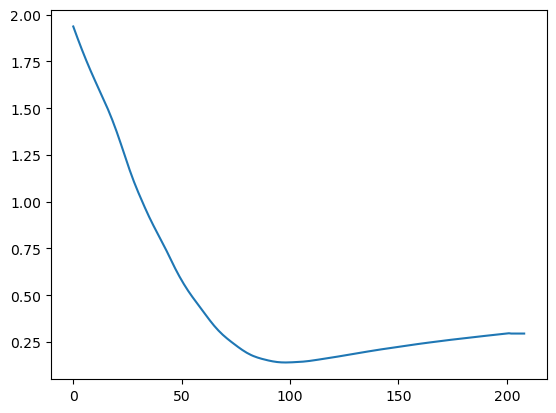

In [6]:
#plt.plot(training_log["training_log"]['likelihood.noise_covar.raw_noise'])
plt.plot(training_log["likelihood_log"])

In [7]:
metrics.calculate_laplace(model, -loss, with_prior=True, param_punish_term=-1.0)


(tensor(-2.2947, dtype=torch.float64, grad_fn=<AddBackward0>),
 {'neg MLL': tensor(0.2947, grad_fn=<NegBackward0>),
  'punish term': tensor(-2.0001, dtype=torch.float64),
  'punish without replacement': tensor(5.2930, dtype=torch.float64),
  'laplace without replacement': tensor(4.9983, dtype=torch.float64, grad_fn=<SubBackward0>),
  'num_replaced': tensor(2),
  'parameter list': ['likelihood.noise_covar.raw_noise',
   'covar_module.raw_lengthscale'],
  'parameter values': tensor([[-11.4403],
          [  1.8133]]),
  'corrected Hessian': tensor([[46.4268,  0.0000],
          [ 0.0000, 46.4268]], dtype=torch.float64),
  'diag(constructed eigvals)': tensor([46.4268, 46.4268], dtype=torch.float64),
  'original symmetrized Hessian': tensor([[0.0139, 0.0082],
          [0.0082, 0.0769]], dtype=torch.float64),
  'prior mean': tensor([[-3.5164],
          [-0.2122]], dtype=torch.float64),
  'diag(prior var)': tensor([12.8388,  3.5704], dtype=torch.float64),
  'likelihood approximation': tens

In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = model(train_x)
    observed_pred = likelihood(output)
    

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [9]:
observed_pred.covariance_matrix

tensor([[ 2.0725e-04,  2.7955e-05, -7.9274e-06, -1.3113e-05,  6.9737e-06],
        [ 2.7955e-05,  1.5534e-04,  3.6895e-05,  1.4186e-05, -1.3590e-05],
        [-7.9274e-06,  3.6895e-05,  1.6315e-04,  3.6955e-05, -7.9870e-06],
        [-1.3173e-05,  1.4186e-05,  3.6955e-05,  1.5534e-04,  2.8014e-05],
        [ 6.9737e-06, -1.3590e-05, -7.9870e-06,  2.8014e-05,  2.0761e-04]])

In [10]:
observed_pred.loc

tensor([0.0021, 0.2460, 0.5004, 0.7544, 0.9969])

In [11]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 1000, log_param_path=True, log_full_likelihood=True)
MC_logs = dict()
print(MCMC_approx)
print(MC_log)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_gfm4it5p/model_3fzp33pw.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_gfm4it5p/model_3fzp33pw.stan', line 32, column 97 to
    column 105, the value of v depends on parameter(s): theta.
Warning in '/tmp/httpstan_gfm4it5p/model_3fzp33pw.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_gfm4it5p/model_3fzp33pw.stan', line 32, column 51 to
    column 59, the value of v depends on parameter(s): theta.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%


Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/tmp/httpstan_bo63oqgh/model_3fzp33pw.stan', line 34, column 8 to column 32)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: multi_normal_lpdf: Covariance matrix is

tensor(-149.1557)
{'Kernel code': '\n    functions {\n        array[] real softplus(array[] real v){\n            array[num_elements(v)] real r;\n            for (d in 1:num_elements(v)){\n                r[d] = log(1.0 + exp(v[d]));\n            }\n            return r;\n        }\n        real softplus(real v){\n            return log(1.0 + exp(v));\n        }\n    }\n    \n    data {\n        int N;\n        int D;\n        array[N] real x;\n        vector[N] y;\n        vector[D] t_mu;\n        matrix[D, D] t_sigma;\n    }\n    \n    parameters {\n        vector<lower=-3.0>[D] theta;\n    }\n    \n    model {\n        matrix[N, N] K;\n        vector[N] mu;\n        theta ~ multi_normal(t_mu, t_sigma);\n        K = (identity_matrix(dims(x)[1]).*softplus(theta[1])) + gp_exp_quad_cov(x, 1.0, softplus(theta[2]));\n        mu = zeros_vector(N);\n        y ~ multi_normal(mu, K);\n    }\n    ', 'seed': 132244, 'Likelihood time': 1.482344150543213, 'Model compile time': 0.00973105430603027